# Fitting PRFs in K2 TPFs from Campaign 9.1

In this simple tutorial we will show how to perform PRF photometry in a K2 target pixel file using ``PyKE`` and ``oktopus``.

**This notebook was created with the following versions of PyKE and oktopus:**

In [1]:
import pyke

In [2]:
pyke.__version__

'3.1.dev'

In [3]:
import oktopus

In [4]:
oktopus.__version__

'0.1.dev9'

**1. Importing the necessary packages**

As usual, let's start by importing the packages from the standard scientific Python stack:

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
font = {'family' : 'serif',
        'size'   : 22,
        'serif'  : 'New Century Schoolbook'}
rc('font', **font)

Since we will perform PRF photometry in a TPF, let's import ``KeplerTargetPixelFile`` and ``KeplerQualityFlags`` classes from ``PyKE``:

In [6]:
from pyke import KeplerTargetPixelFile, KeplerQualityFlags

It's always wise to take a prior look at the data, therefore, let's import ``photutils`` so that we can perform aperture photometry:

In [7]:
import photutils.aperture as apr

Additionally, we will need a model for the Pixel Response Function and for the scene. We can import those from ``PyKE``, as well.

In [8]:
from pyke.prf_photometry import SimpleKeplerPRF, SceneModel, PRFPhotometry

Finally, we will use ``oktopus`` to handle our statistical assumptions:

In [9]:
from oktopus import UniformPrior

Let's start by instantiating a ``KeplerTargetPixelFile`` object (you may either give a url or a local path to the file):

**2. Actual PRF Photometry**

In [10]:
tpf = KeplerTargetPixelFile('https://archive.stsci.edu/missions/k2/target_pixel_files/c91/'
                            '224300000/64000/ktwo224364733-c91_lpd-targ.fits.gz',
                            quality_bitmask=KeplerQualityFlags.QUALITY_ZERO_BITMASK)

Note that we have set ``quality_bitmask=KeplerQualityFlags.QUALITY_ZERO_BITMASK``, which means that we only care about cadences that have the ``QUALITY`` flag set to zero, i.e., only good quality cadences. Frames that present any other
quality flag will be ignored.

Let's take a look at the pixel data using the ``plot`` method from ``KeplerTargetPixelFile``:

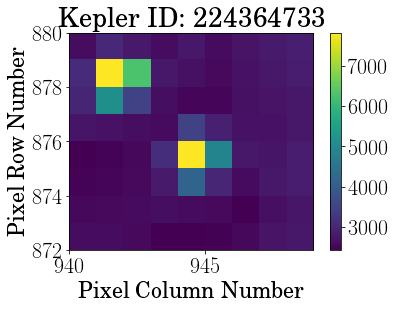

In [11]:
tpf.plot(nframe=100)

Now, let's create circular apertures around the targets using ``photutils``:

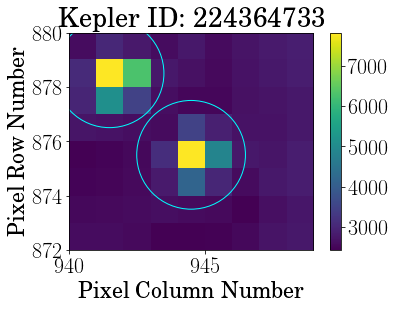

In [12]:
tpf.plot(nframe=100)
apr.CircularAperture((941.5, 878.5), r=2).plot(color='cyan')
apr.CircularAperture((944.5, 875.5), r=2).plot(color='cyan')

We can also use ``photutils`` to create aperture photometry light curves from the drawn apertures:

In [13]:
lc1, lc2 = np.zeros(len(tpf.time)), np.zeros(len(tpf.time))
for i in range(len(tpf.time)):
    lc1[i] = apr.CircularAperture((941.5 - tpf.column, 878.5 - tpf.row), r=2).do_photometry(tpf.flux[i])[0]
    lc2[i] = apr.CircularAperture((944.5 - tpf.column, 875.5 - tpf.row), r=2).do_photometry(tpf.flux[i])[0]

Let's visualize the light curves:

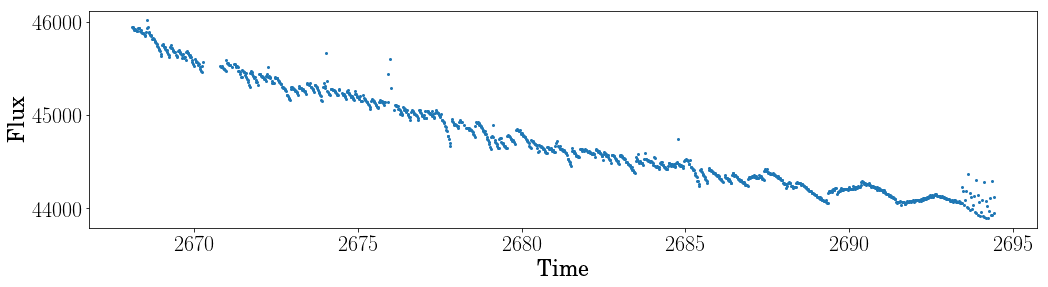

In [14]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, lc1, 'o', markersize=2)
plt.xlabel("Time")
plt.ylabel("Flux")

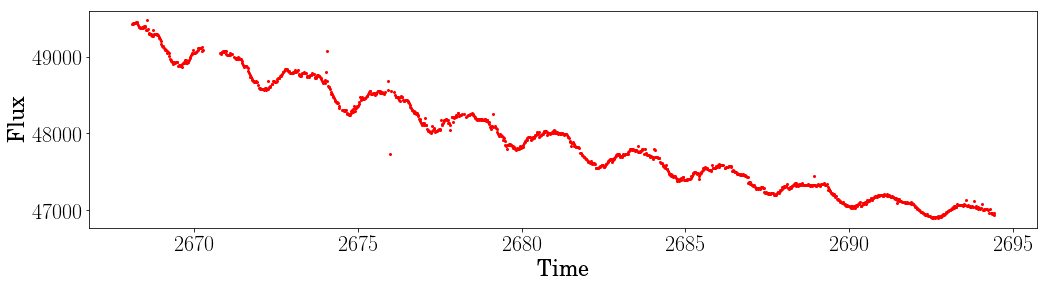

In [15]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, lc2, 'ro', markersize=2)
plt.xlabel("Time")
plt.ylabel("Flux")

Looking at the data before performing PRF photometry is important because it will give us insights on how to construct our priors on the parameters we want to estimate.

Another important part of PRF photometry is the background flux levels. We can either estimate it beforehand and subtract it from the target fluxes or we can let the background be a free parameter during the estimation process. We will choose the latter here, because we will assume that our data comes from Poisson distributions. Therefore, we want the pixel values to be positive everywhere. And, more precisely, remember that the subtraction of two Poisson random variables is not a Poisson rv.

In any case, let's take a look at the background levels using the ``estimate_background_per_pixel`` method from ``KeplerTargetPixelFile`` class.

In [16]:
bkg = tpf.estimate_background_per_pixel()

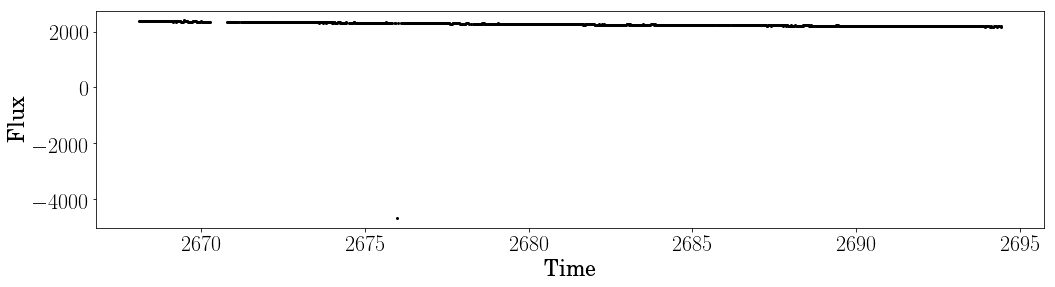

In [17]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, bkg, 'ko', markersize=2)
plt.xlabel("Time")
plt.ylabel("Flux")

Ooops! Looks like there is something funny happening on that frame because the background levels are way bellow zero.
Let's plot the pixel data to see what's going on:

In [18]:
funny_cadence = np.argwhere(bkg < 0)[0][0]

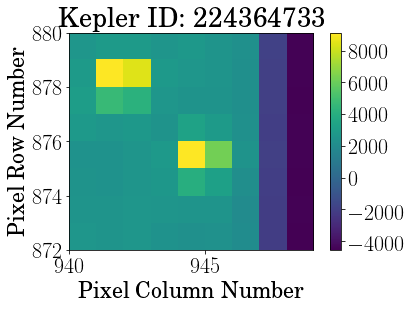

In [19]:
tpf.plot(nframe=funny_cadence)

Ok, we see that there is something unusual here. Let's just ignore this cadence for now and move on to our PRF photometry.

Let's redraw the background light curve using more meaningful bounds:

(2150, 2400)

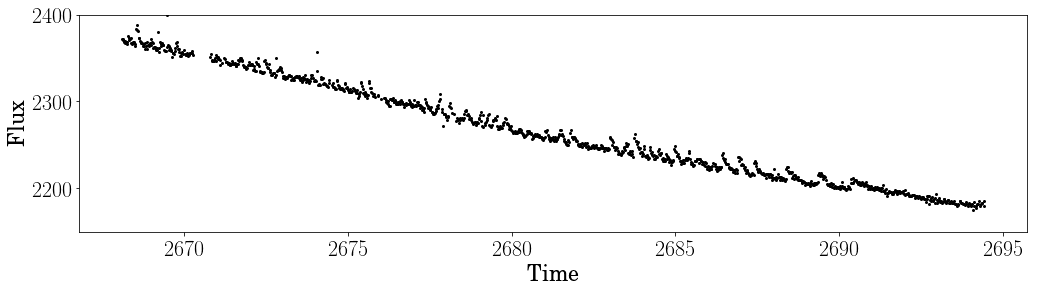

In [20]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, bkg, 'ko', markersize=2)
plt.xlabel("Time")
plt.ylabel("Flux")
plt.ylim(2150, 2400)

Now, let's create our PRF model using the ``SimpleKeplerPRF`` class:

In [21]:
sprf = SimpleKeplerPRF(tpf.channel, tpf.shape[1:], tpf.column, tpf.row)

This is a simple model based on the PRF calibration data. It depends on the channel and the dimensions of the target pixel file that we want to model. This model is parametrized by stellar positions and flux.

To combine one or more PRF models and a background model, we can use the ``SceneModel`` class:

In [22]:
scene = SceneModel(prfs=[sprf] * 2)

Note that this class takes a list of PRF objects as required inputs. Additionally, a parameter named ``bkg_model`` can be used to model the background variations. The default is a constant value for every frame.

Now that we have taken a look at the data and created our model, let's put our assumptions on the table by defining a prior distribution for the parameters.

Let's choose a uniform prior for the whole parameter space, we can do that using the ``UniformPrior`` class:

In [23]:
prior = UniformPrior(lb=[10e3, 940., 877., 10e3, 943., 874., 1e3],
                     ub=[60e3, 944., 880., 60e3, 947., 877., 4e3])

This class takes two parameters: ``lb``, ``ub``. ``lb`` stands for lower bound and ``ub`` for upper bound.
The order of those values should correspond to the order of the parameters in our model. For example, an object from
``SimpleKeplerPRF`` takes ``flux``, ``center_col``, and ``center_row``. Therefore, we need to define the prior values on that same order. And since we have two targets, that results in six parameters that have to be defined. The last parameter is the background constant.

Let's visualize our model evaluated at the mean value of given by our prior probablity:

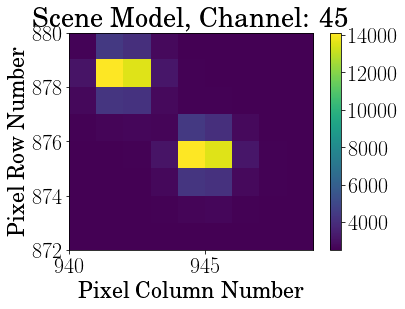

In [24]:
scene.plot(*prior.mean)

Now, we can feed both the ``SceneModel`` and the ``UniformPrior`` objects to the ``PRFPhotometry`` class:

In [25]:
phot = PRFPhotometry(scene_model=scene, prior=prior)

Finally, we use the ``fit`` method in which we have to pass the pixel data ``tpf.flux``.

In [26]:
phot.fit(tpf.flux)

  0%|          | 0/1213 [00:00<?, ?it/s]/Users/jvmirca/anaconda3/lib/python3.6/site-packages/autograd/core.py:82: RuntimeWarning: invalid value encountered in log
  result_value = self.fun(*argvals, **kwargs)
/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
 28%|██▊       | 341/1213 [00:17<00:39, 21.80it/s]/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1851: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1852: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
100%|██████████| 1213/1213 [00:57<00:00, 20.95it/s]


Note that our Poisson likelihood assumption is embedded in the ``PRFPhotometry`` class. That can be changed while creating ``PRFPhotometry`` through the ``loss_function`` parameter.

Now, let's retrieve the fitted parameters which are store in the ``opt_params`` attribute:

In [27]:
flux_1 = phot.opt_params[:, 0]
xcenter_1 = phot.opt_params[:, 1]
ycenter_1 = phot.opt_params[:, 2]
flux_2 = phot.opt_params[:, 3]
xcenter_2 = phot.opt_params[:, 4]
ycenter_2 = phot.opt_params[:, 5]
bkg_hat = phot.opt_params[:, 6]

Let's visualize the parameters as a function of time:

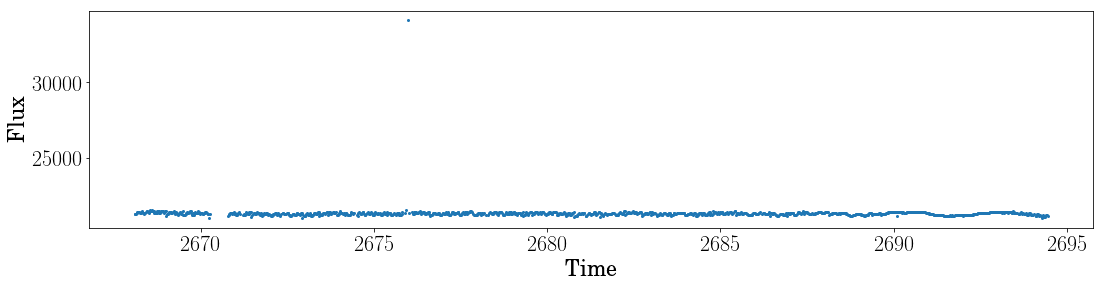

In [28]:
plt.figure(figsize=[18, 4])
plt.plot(tpf.time, flux_1, 'o', markersize=2)
plt.ylabel("Flux")
plt.xlabel("Time")

Oops! That outlier is probably the funny cadence we identified before:

In [29]:
outlier = np.argwhere(flux_1 > 30000)[0][0]

In [30]:
outlier == funny_cadence

True

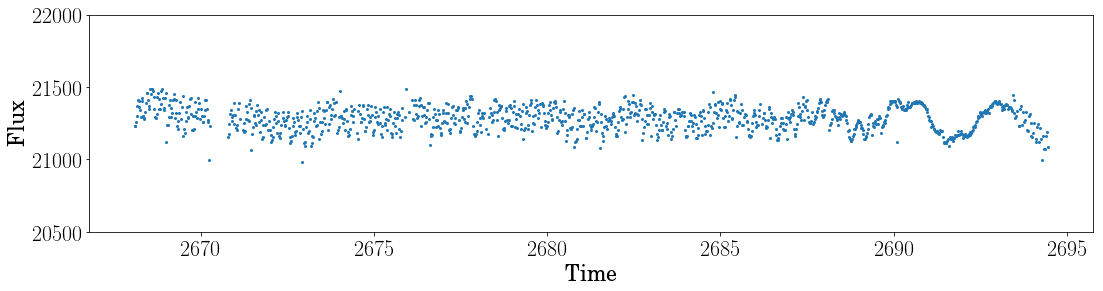

In [31]:
plt.figure(figsize=[18, 4])
plt.plot(tpf.time, flux_1, 'o', markersize=2)
plt.ylim(20500, 22000)
plt.ylabel("Flux")
plt.xlabel("Time")

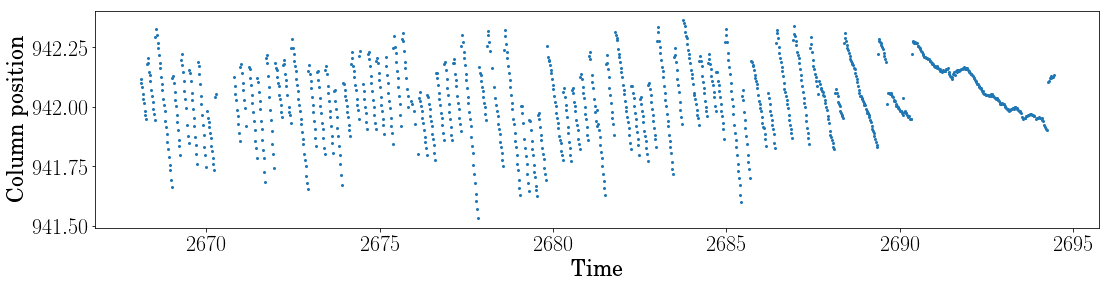

In [32]:
plt.figure(figsize=[18, 4])
plt.plot(tpf.time, xcenter_1, 'o', markersize=2)
plt.ylabel("Column position")
plt.xlabel("Time")

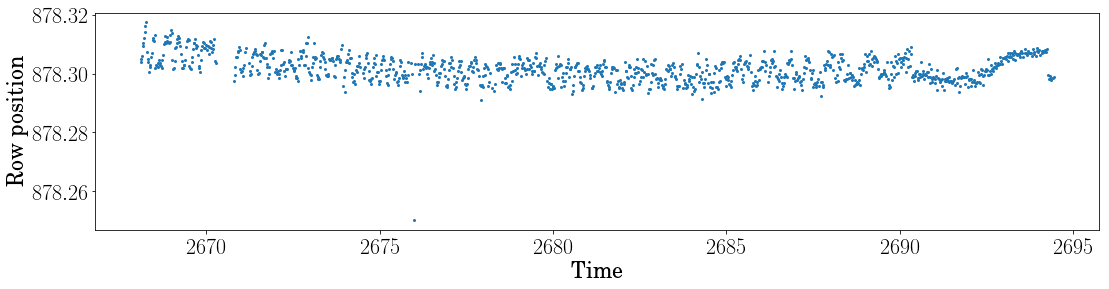

In [33]:
plt.figure(figsize=[18, 4])
plt.plot(tpf.time, ycenter_1, 'o', markersize=2)
plt.ylabel("Row position")
plt.xlabel("Time")

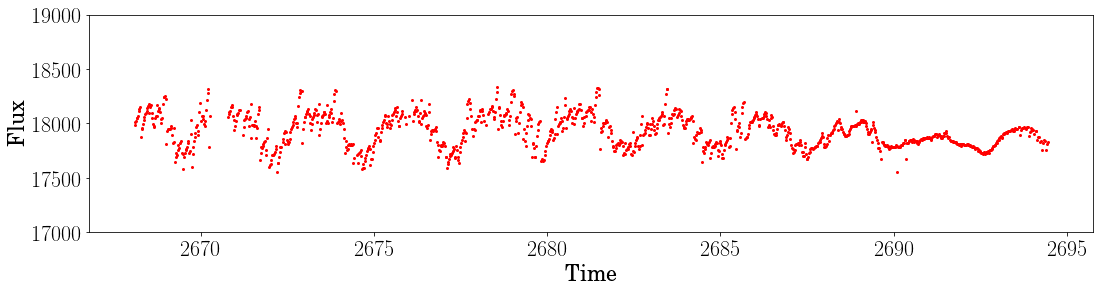

In [34]:
plt.figure(figsize=[18, 4])
plt.plot(tpf.time, flux_2, 'ro', markersize=2)
plt.ylim(17000, 19000)
plt.ylabel("Flux")
plt.xlabel("Time")

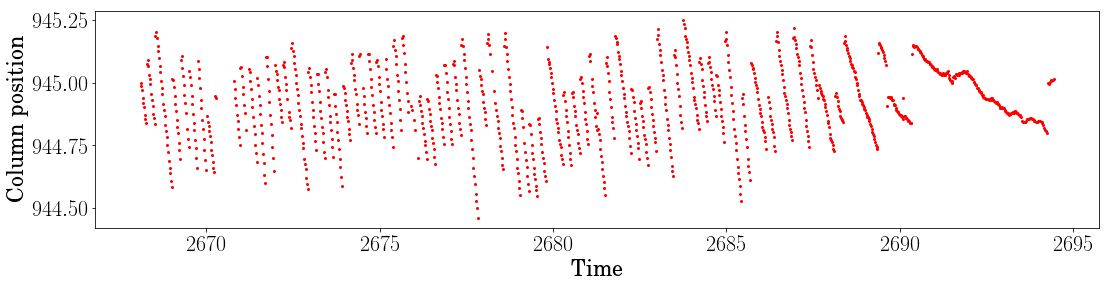

In [35]:
plt.figure(figsize=[18, 4])
plt.plot(tpf.time, xcenter_2, 'ro', markersize=2)
plt.ylabel("Column position")
plt.xlabel("Time")

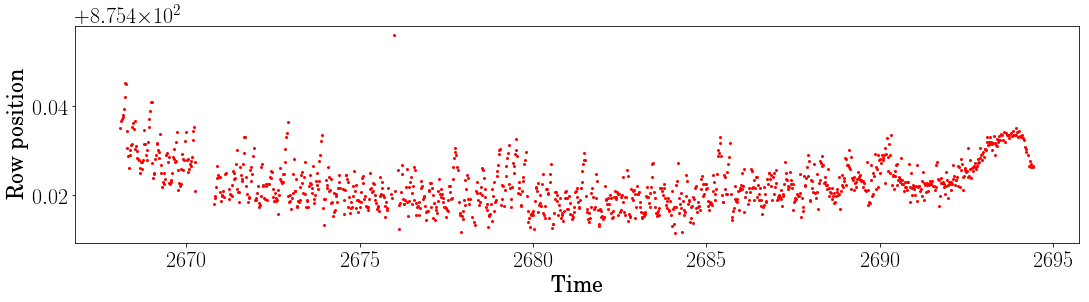

In [36]:
plt.figure(figsize=[18, 4])
plt.plot(tpf.time, ycenter_2, 'ro', markersize=2)
plt.ylabel("Row position")
plt.xlabel("Time")

(2350, 2650)

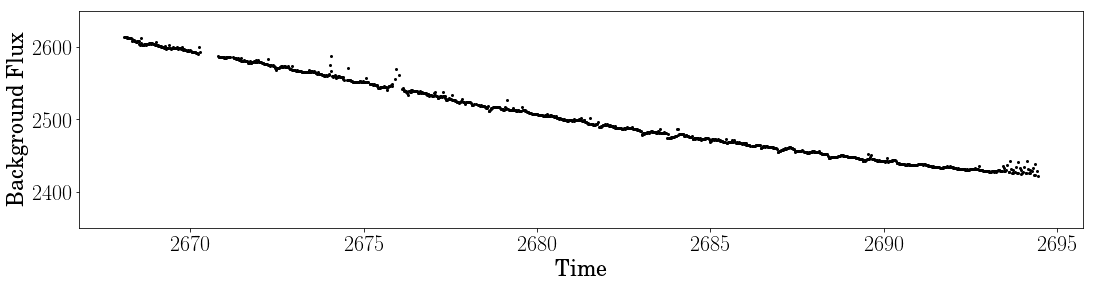

In [37]:
plt.figure(figsize=[18, 4])
plt.plot(tpf.time, bkg_hat, 'ko', markersize=2)
plt.ylabel("Background Flux")
plt.xlabel("Time")
plt.ylim(2350, 2650)

We can retrieve the residuals using the ``get_residuals`` method:

In [38]:
residuals = phot.get_residuals()

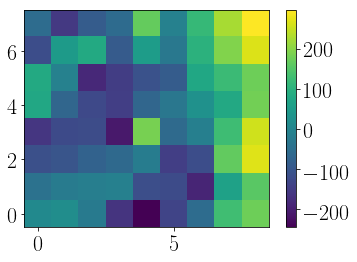

In [39]:
plt.imshow(residuals[100], origin='lower')
plt.colorbar()

We can also get the pixels time series for every single model as shown below:

In [40]:
import tqdm

In [41]:
prf_1 = np.array([scene.prfs[0](*phot.opt_params[i, 0:3])
                  for i in tqdm.tqdm(range(len(tpf.time)))])

100%|██████████| 1213/1213 [00:00<00:00, 23099.93it/s]


In [42]:
prf_2 = np.array([scene.prfs[1](*phot.opt_params[i, 3:6])
                  for i in tqdm.tqdm(range(len(tpf.time)))])

100%|██████████| 1213/1213 [00:00<00:00, 25314.04it/s]


Let's then visualize the single models:

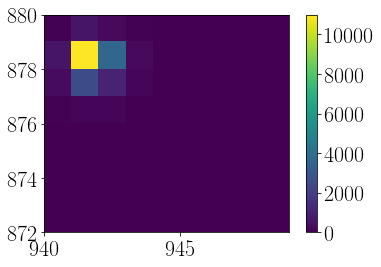

In [43]:
plt.imshow(prf_1[100], origin='lower', extent=(940, 949, 872, 880))
plt.colorbar()

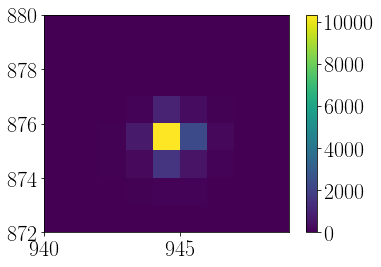

In [44]:
plt.imshow(prf_2[100], origin='lower', extent=(940, 949, 872, 880))
plt.colorbar()